In [2]:
import numpy as np
import mne

### Reading Data

In [3]:
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = (sample_data_folder / 'MEG' / 'sample' /
                        'sample_audvis_filt-0-40_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file)

Using default location ~/mne_data for sample...
Creating ~/mne_data


100%|██████████████████████████████████████| 1.65G/1.65G [00:00<00:00, 829GB/s]
Untarring contents of '/Users/fayyaanyatasia/mne_data/MNE-sample-data-processed.tar.gz' to '/Users/fayyaanyatasia/mne_data'


Attempting to create new mne-python configuration file:
/Users/fayyaanyatasia/.mne/mne-python.json
Opening raw data file /Users/fayyaanyatasia/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


In [4]:
raw

<Raw | sample_audvis_filt-0-40_raw.fif, 376 x 41700 (277.7 s), ~3.3 MB, data not loaded>

<Info | 15 non-empty values
 bads: 2 items (MEG 2443, EEG 053)
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 Gradiometers, 102 Magnetometers, 9 Stimulus, 60 EEG, 1 EOG
 custom_ref_applied: False
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 376
 projs: PCA-v1: off, PCA-v2: off, PCA-v3: off, Average EEG reference: off
 sfreq: 150.2 Hz
>

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 13.639 (s)
Using qt as 2D backend.


/Users/fayyaanyatasia/anaconda3/envs/mne/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


Using pyopengl with version 3.1.6


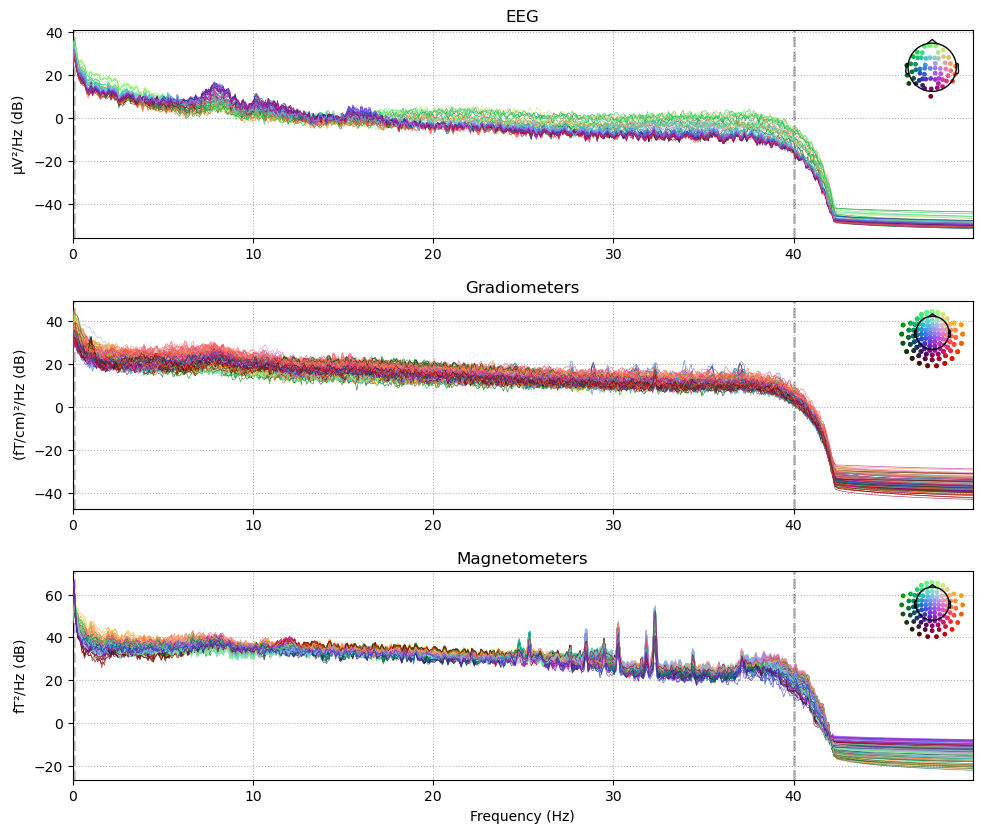

Channels marked as bad:
['MEG 2443', 'EEG 053']


In [7]:
raw.plot_psd(fmax=50)
raw.plot(duration=5, n_channels=30)

### Preprocessing

Fitting ICA to data using 364 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 7.2s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated


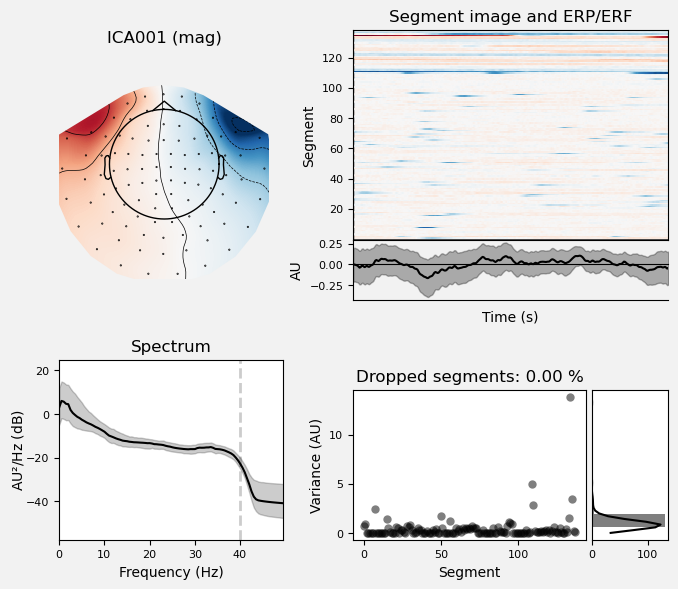

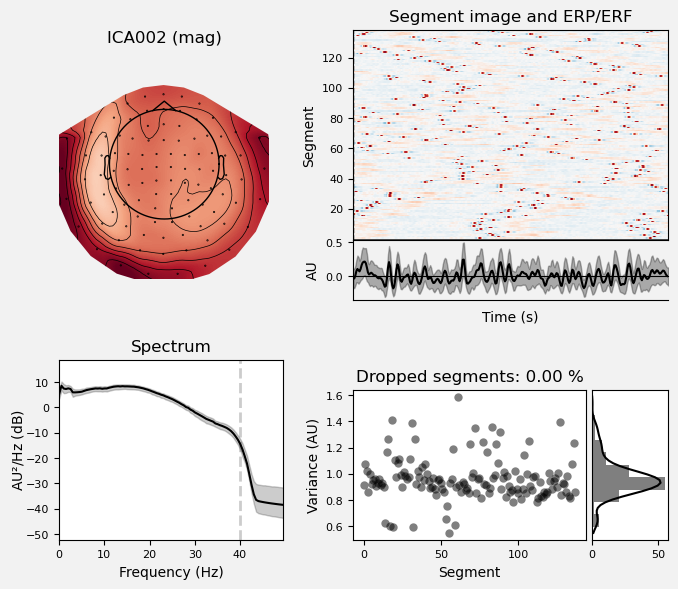

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [8]:
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw)
ica.exclude = [1, 2]  # details on how we picked these are omitted here
ica.plot_properties(raw, picks=ica.exclude)

In [10]:
orig_raw = raw.copy()
raw.load_data()
ica.apply(raw)

# show some frontal channels to clearly illustrate the artifact removal
chs = ['MEG 0111', 'MEG 0121', 'MEG 0131', 'MEG 0211', 'MEG 0221', 'MEG 0231',
       'MEG 0311', 'MEG 0321', 'MEG 0331', 'MEG 1511', 'MEG 1521', 'MEG 1531',
       'EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006',
       'EEG 007', 'EEG 008']
chan_idxs = [raw.ch_names.index(ch) for ch in chs]
orig_raw.plot(order=chan_idxs, start=12, duration=4)
raw.plot(order=chan_idxs, start=12, duration=4)

Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 364 PCA components
Using pyopengl with version 3.1.6
Using pyopengl with version 3.1.6


### Detecting Events

In [11]:
events = mne.find_events(raw, stim_channel='STI 014')
print(events[:5])

319 events found
Event IDs: [ 1  2  3  4  5 32]
[[6994    0    2]
 [7086    0    3]
 [7192    0    1]
 [7304    0    4]
 [7413    0    2]]


In [12]:
event_dict = {'auditory/left': 1, 'auditory/right': 2, 'visual/left': 3,
              'visual/right': 4, 'smiley': 5, 'buttonpress': 32}

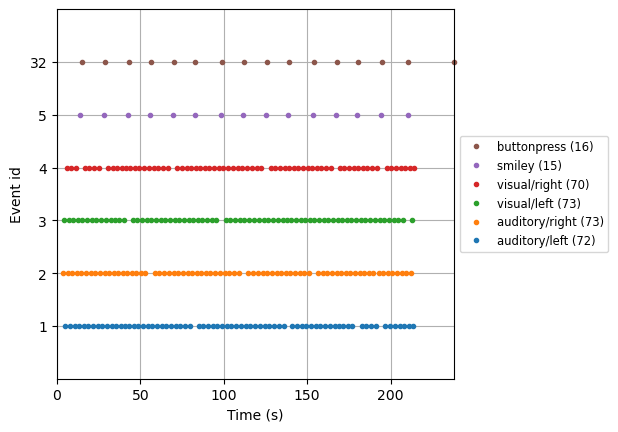

In [13]:
fig = mne.viz.plot_events(events, event_id=event_dict, sfreq=raw.info['sfreq'],
                          first_samp=raw.first_samp)

### Epoching

In [14]:
reject_criteria = dict(mag=4000e-15,     # 4000 fT
                       grad=4000e-13,    # 4000 fT/cm
                       eeg=150e-6,       # 150 µV
                       eog=250e-6)       # 250 µV

In [15]:
epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=-0.2, tmax=0.5,
                    reject=reject_criteria, preload=True)

Not setting metadata
319 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Using data from preloaded Raw for 319 events and 106 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EEG : ['EEG 008']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
10 bad epochs dropped


In [16]:
conds_we_care_about = ['auditory/left', 'auditory/right',
                       'visual/left', 'visual/right']
epochs.equalize_event_counts(conds_we_care_about)  # this operates in-place
aud_epochs = epochs['auditory']
vis_epochs = epochs['visual']
del raw, epochs  # free up memory

Dropped 7 epochs: 121, 195, 258, 271, 273, 274, 275


Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated


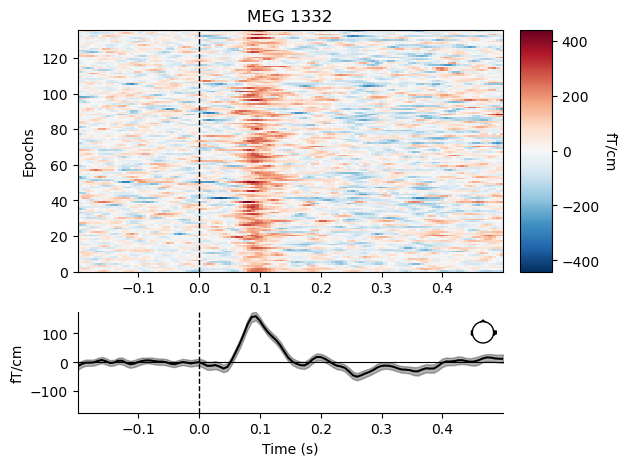

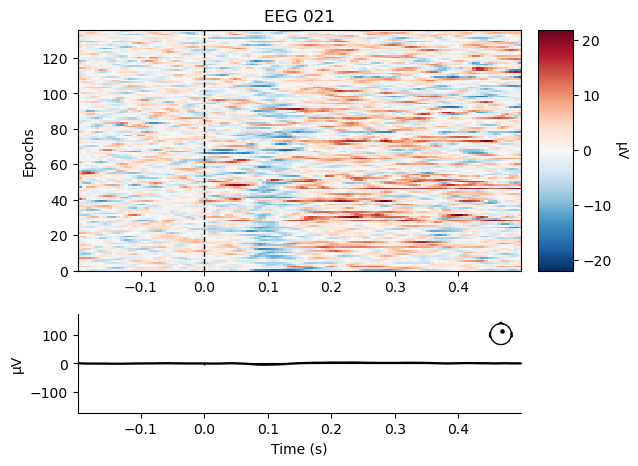

[<Figure size 640x480 with 4 Axes>, <Figure size 640x480 with 4 Axes>]

In [17]:
aud_epochs.plot_image(picks=['MEG 1332', 'EEG 021'])

### Estimated Evoked Response

Multiple channel types selected, returning one figure per type.
combining channels using "gfp"
combining channels using "gfp"


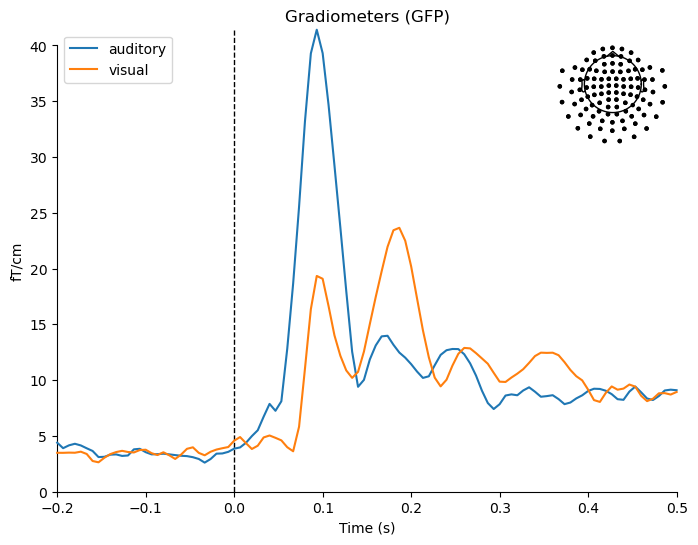

combining channels using "gfp"
combining channels using "gfp"


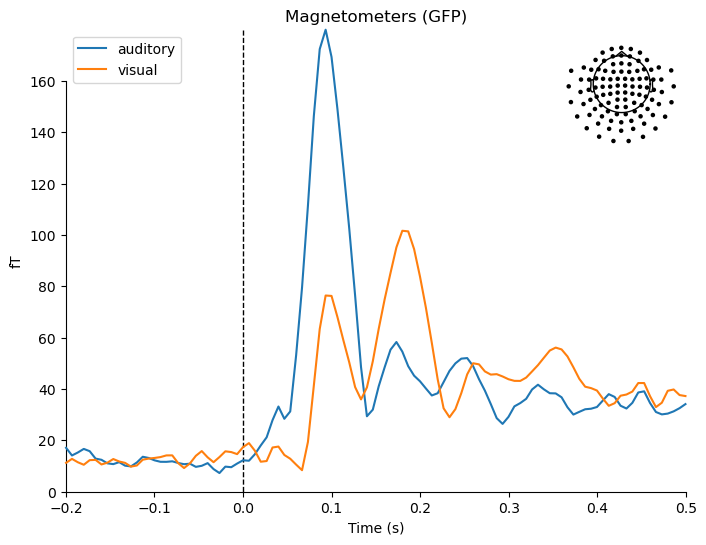

combining channels using "gfp"
combining channels using "gfp"


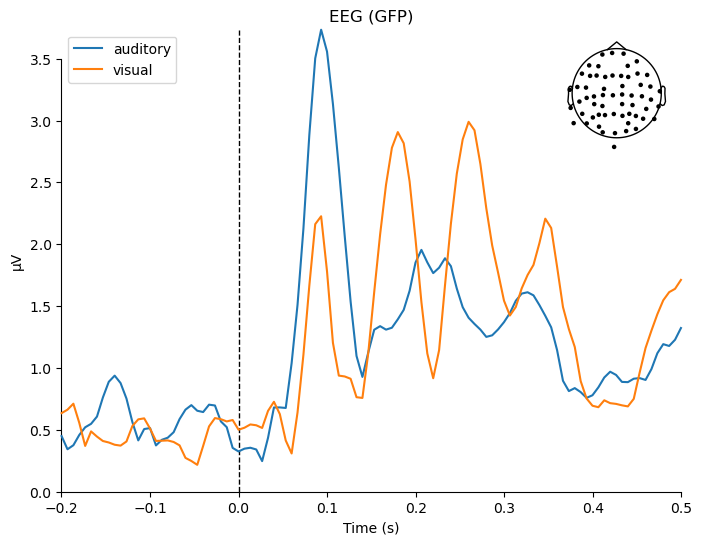

[<Figure size 800x600 with 2 Axes>,
 <Figure size 800x600 with 2 Axes>,
 <Figure size 800x600 with 2 Axes>]

In [18]:
aud_evoked = aud_epochs.average()
vis_evoked = vis_epochs.average()

mne.viz.plot_compare_evokeds(dict(auditory=aud_evoked, visual=vis_evoked),
                             legend='upper left', show_sensors='upper right')

### 